<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h1>Applied Data Analysis </h1>
<h1>ATM/MPO 624, spring 2020</h1>
<h2>Modeling the meaning of our data</h2>
<h3>Epidemic math, then problems from/for our 6 class participants' efforts</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Science from data: models of its meaning
1. <a href="#epidemic">Simplest epidemic model</a>
1. <a href="#amy">Dilution and chemistry with age: Amy's problem</a>
1. <a href="#yueyang">Eddies and mean zonal current: Yueyang's work</a>
1. <a href="#ivenis">Regressing signals in gappy SSH series: Ivenis' data</a>
1. <a href="#sisam">Averaging and emergent constraints in CERES grids: Sisam's challenge</a>
1. <a href="#tyler">NAO and PDO Index time series variance and prediction: Tyler's work</a>
1. <a href="#kelsey">Global maps regressed on climate time series (by web): Kelsey's field</a>
1. <a href="#haozhe">Haozhe, are you out there? Got a project to show/share?</a>

<a name="epidemic"></a>
# Simple model of an epidemic: do problems at end

### Definitions: Vulnerable, Sick, Immune

Consider a fixed population (no birth or death) that can be subdivided into 3 categories: Vulnerable V, Sick S, and Recovered R. Model the transition from one state to another through infection and recovery processes. **How?** 

#### Infection
Infection involves an encounter between S and V, with a lot of details we can't know. Whatever those details, we postulate that *infection doubles if S is doubled, or if V is doubled.* From this simple idea, the term must be a product (this is just like chemical kinetics). All the details can be encapsulated in a coefficient *k*, which lumps together both the social likelihood of close-range interaction and infection process details.  

$dS/dt_{infection} = k \times S \times V$

#### Recovery
Sick people recover at some rate, and then are not vulnerable. If twice as many are sick, twice as many recover, so perhaps this proportionality is best modeled as a simple time decay:   

$dS/dt_{recovery} = -S / \tau$

#### Model

$dS/dt_{infection} = kSV - S / \tau$

$dV/dt_{infection} = -kSV$

$dR/dt_{infection} = + S / \tau$



## Epidemic problems: 

1. What is the d/dt equation for V+S+R? (Just add the 3 equations). Discuss what processes we didn't include. 

1. What is the d/dt equation for total cases S+R? 

1. In the very early stages (t << $\tau$, so that R << S, and V >> S is almost a constant, what is the solution S(t)? 

1. (**extra credit**) Is there an analytic solution for the more general case? 

1. We don't like that S(t) from 3., so we take steps that we hope might change the value of k. But perhaps those don't fully kick in until t > $\tau$, an epoch when R is increasing and V begins to decrease as a signficant fraction of people have had the disease. Can we discern with data the difference between V decreasing and a decrease in the value of k? Discuss. 

1. Suppose $kV(0) =$ 3 days, and $\tau = $ 10 days. Use a log10 scale on the y axis, in light of solution 3. above. Make it look like http://bmcnoldy.rsmas.miami.edu/covid19/ if you can. [Is the math too hard for people to understand?](https://www.forbes.com/sites/marshallshepherd/2020/03/23/is-the-math-too-hard-for-people-to-understand-covid-19-coronavirus) Play with k at various times, to see when and how its effect can be discerned and how that differs, from the situation where k remains constant and the infection simply runs out of V to infect. 

1. **Why bother with the code below when [this thing](https://gabgoh.github.io/COVID/index.html) exists?** Well, it was fun to give it a stab, and find out the Professional approach is not far from the simple ideas above!  

In [1]:
# Poor man's epidemic calculator, 
# but just visit https://gabgoh.github.io/COVID/index.html

import numpy as np

# Day 1 setup. Time is discrete in days, starting at day 1 (array element 0)
day = [1]
V = [3.0e9] # 300 million
S = [1.0]
R = [0.0]

# Parameters: kV(0) = 3 days
k0 = 3/V[0]
k = k0
tau = 15. 

# simple forward time stepping by one day
for iday in np.arange(2,365): 
    # print('day ',iday)
    if (iday > 7): 
        k = k0/100
    day.append([iday])
    S.append(np.floor( S[iday-2] + k*S[iday-2]*V[iday-2]) )
    R.append(np.floor( R[iday-2]                         + S[iday-2]/tau) )
    V.append(np.floor( V[iday-2] - k*S[iday-2]*V[iday-2] - S[iday-2]/tau) )

Populating the interactive namespace from numpy and matplotlib


findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


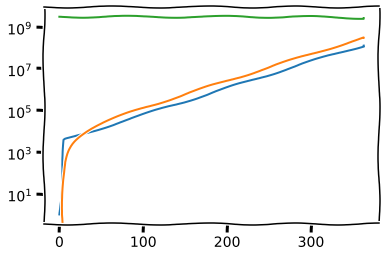

In [2]:
# quick and dirty plotting, looks like my crude time stepping is unstable
%pylab inline 
plt.xkcd() # whiteboard-like whimsical style 
plt.yscale('log')

plot( np.transpose([S,R,V]) )

In [3]:
plt.yscale?

Signature: plt.yscale(value, **kwargs)
Docstring:
Set the y-axis scale.

Parameters
----------
value : {"linear", "log", "symlog", "logit", ...}
    The axis scale type to apply.

**kwargs
    Different keyword arguments are accepted, depending on the scale.
    See the respective class keyword arguments:

    - `matplotlib.scale.LinearScale`
    - `matplotlib.scale.LogScale`
    - `matplotlib.scale.SymmetricalLogScale`
    - `matplotlib.scale.LogitScale`


Notes
-----
By default, Matplotlib supports the above mentioned scales.
Additionally, custom scales may be registered using
`matplotlib.scale.register_scale`. These scales can then also
be used here.
File:      ~/anaconda3/envs/unidata/lib/python3.7/site-packages/matplotlib/pyplot.py
Type:      function


<a href="#top">Back to top </a>

<a name="amy"></a>
# Dilution & chemistry: all do problems; Amy do with data?

## Chemical plume dilution (spread) and aging

Suppose a unit puff of polluted air has a width W that grows exponentially with time by entrainment e ($dW/dt = eW$), and a depth D that grows more slowly and linearly with a constant deepening rate d ($dD/dt = d$). 

Suppose this puff contains an initial mass $M_B$ of substance B, which remains constant with time (no chemical aging), and masses $M_A$ and $M_C$ of two other substances A and C which exponentially decay with time on time scales of $\tau_A$ and $\tau_C$. The whole model for concentrations is thus:

#### Plume spread:
$dW/dt = eW$

$dD/dt = d$

#### Decay of substances A and C
$dM_A/dt = -M_A/\tau_A$

$dM_C/dt = -M_C/\tau_C$

#### Dilution gives concentrations (the measured thing)
$c_B = M_B / (W*D) $

$c_A = M_A / (W*D) $

$c_C = M_C / (W*D) $


### Problems: 

1. If t=0 is the time this puff begins obeying this equation (that is, the time at which the messy surface fire emissions have become a "puff" in the atmosphere), what is the age decay of the concentration $c_B(t)$ in terms of parameters d and e?  

1. Use the toy code below to show and explain how the ratios $c_A/c_B$ and $c_C/c_B$ are more tractable to study than the directly observed quantities $c_A$ and $c_B$. 

1. How would you estimate $\tau_A$ from observations of $c_A(t)$ at known ages (times) t? 

**(This is just my crude recall of Amy's earlier notebook from her [fork](https://github.com/amiedobracki/MPO624-2020)). Amy feel free to take over & make it make better sense!**

In [ ]:
# Toy model code - Amy is this any help? 

t = np.arange(0,240) # let's call them hours

# Plume spread
W0 = 100             # let's call them km
D0 = 2               # let's call them km 
e = 1./72            # an e-folding of W in 3 days
d = 0.01             # deepens at 1% per hour
# Hooray exact solutions, no numerical instability like in the epidemic graph
W = W0 * exp(e*t)
D = D0 * (1 + d*t) 

# Concentrations: masses divided by plume volume 
MB0 = 
MA0 = 
MC0 = 
tauA = 
tauC = 

MB = MB0 
MA = MA0 * exp(-t/tauA) # again, exact solutions, no time stepping needed
MC = MC0 * exp(-t/tauC)

cB = MB /W/D 
cA = MA /W/D
cC = MC /W/D

plot()

<a href="#top">Back to top </a>

<a name="yueyang"></a>
# Eddies and mean flow; Yueyang model it better with data?

## How does eddy momentum flux relate to mean shear?

Suppose we have velocity (u and v as usual) in an x,y,t domain. Use the square bracket like \[u\](y,t) to express a zonal mean along the x axis, while u\*(x,y,t) = u(x,y,t)-\[u\](y,t) indicates *eddy* deviations from that zonal mean. 

Eddy u-momentum flux in the meridional dimension is EMF = [u\*v\*]. Its convergence EMFC = $-\partial/\partial y(EMF)$. 

### Modeling the interactions

We might postulate that eddy magnitude EM grows wherever the zonal mean absolute vorticity has a gradient, as strips of vorticity internal to a fluid are known to roll up into balls of vorticity by [shear instability](http://hmf.enseeiht.fr/travaux/CD0001/travaux/optmfn/hi/01pa/hyb72/kh/kh1.gif)). 

$\partial/\partial t(EM) = k_1 \partial/\partial y(f + \partial [u]/\partial y)$

We might postulate that EMF increases wherever round eddies spend time in shear, becoming tilted. 

$\partial/\partial t(EMF) = k_2 (EM)\partial [u]/\partial y$


We might postulate that shear evolves according to EMFC and a simple damping: 

$\partial [u]/\partial t = EMFC - [u]/\tau $

Yueyang what do you think? Maybe it's like [this paper](https://journals.ametsoc.org/doi/pdf/10.1175/JPO-D-15-0139.1)... haven't read it... 

**(This is just my crude recall of Yueyang's earlier notebook from his [fork](https://github.com/LuluTex/MPO624-2020)). Yueyang, feel free to take over & make it make better sense!**

<a href="#top">Back to top </a>

<a name="ivenis"></a>
# Extracting signals: all do problems; Ivenis do with data?

## Can seasonality and trend be estimated from a gappy time series?

Consider the matrix equation for a data table **d** (perhaps with just one column: a time series with gaps). We can decompose or model that data series as a linear sum of M terms.

Each term is a postulated predictor time series, evaluated on the same possibly-gappy time axis as **d**, multiplied by a coefficient we will solve for. 

The table of all those predictors (each predictor being a column vector) is called **G**. The column vector of M coefficients is called **m**. In other words, we postulate this linear model for the data: 

**d** = **G** **m** + residual

To estimate the best **m**, called $m_{est}$, we do a least-squares fit. (As we saw in class, minimizing the summed squared error is the same as choosing **m** so that the residual is uncorrelated with all the columns of **G**).  

Left-multiplying matrices in order to solve for **m**, with a prime for transpose and inv() for the matrix inverse, we get in two steps: 

**d'd** = **d'G** **m**

**inv(d'G)(d'd)** = **m** 

or 

**m** = **(d'G)\\(d'd)** in Matlab's clever notation for left-multiplying by an inverse. 


#### Problem for everyone 

See slide 32 in lecture lec09 [here](http://www.ldeo.columbia.edu/users/menke/edawm/eda_lectures/). This is based on Ch. 6 of  this [e-book](https://miami-primo.hosted.exlibrisgroup.com/primo-explore/fulldisplay?docid=01UOML_ALMA51300698040002976&context=L&vid=uml_new&lang=en_US&search_scope=default_scope&adaptor=Local%20Search%20Engine&isFrbr=true&tab=default_tab&query=any,contains,environmental%20data%20analysis&sortby=date&facet=frbrgroupid,include,615420309&offset=0), if you want to read a text about it. 

1. Write the **G** matrix in slide 32 with just 4 columns: the mean, a trend, and the seasonal cycle (sine and cosine components, most easily interpreted if you use a solstice as t=0). 

1. What is the variance of a linear trend with range M over a time interval? The trend goes from -M/2 to M/2 in the time interval [0,T]. To answer, sketch it, square it, and average that over the interval to get the variance in terms of M. $var(trend) = \int_{0}^{T}Mt dt$

1. What is the variance of a sinusioidal wave of amplitude A? To answer, aquare and average sin() or cos() functions over the interval [0,$2\pi$]. Hint: it helps to remember that $sin^2 + cos^2 = 1$, and note that the variance of sin and cos are equal. 

1. Since the column of ones captures the mean value of the time series **d**, the trend term needs a form like $t-\overline t$. What is the needed form of that $\overline t$ for a gappy data record? Is it the true average of t over the time interval spanned by the data, or the simple average of t for all the available times? Explain. 


Ivenis, might you be able to use the Matlab code of problem eda06_02.m in the supplemental code .zip file at [this site](https://www.ldeo.columbia.edu/users/menke/edawm/) to do the above exercise: fitting your data as a mean, seasonal cycle, and trend without any need for gap filling. 


**(This is just my crude recall of Ivenis's earlier work, maybe in Matlab and not in his [fork](https://github.com/ivenispita/MPO624-2020))? Ivenis, feel free to take over & make it make better sense!**

<a href="#top">Back to top </a>

<a name="sisam"></a>
# Averaging notation: all do problems; Sisam and Haozhe try with data?

## Subdividing time into different timescales

Sisam has radiation datasets at surface and top of atmosphere, longwave and shortwave, upwelling and downwelling. Sums and differences are radiative budgets for the surface, atmosphere, or whole column. She has these for all-sky and clear-sky conditions, so clever differences can isolate the cloud effect C (sometimes called CRE, cloud radiative impacts). From upwelling longwave at the ocean surface, one could compute SST by inverting $LWUP_{sfc} = 0.98 \sigma (SST)^4$ since 0.98 is the emissivity of sea water. 

Let's rewrite C's shape as a function of longitude, latitude, and time  

$C(\lambda,\phi, t)$

in a clever way, subdividing time into year (yyyy), day-of year (doy), and hour of day (hod) in an astronomical form:

$C(\lambda,\phi, yyyy, doy, hod)$

or in a  calendar-clock form as:

$C(\lambda,\phi, yyyy, mm, dd, hh)$


### Problems for all

1. Show that the area-average over the Earth's surface requires a cosine-weighting of latitude:  

$\int_{0}^{360} \int_{-90}^{90} C(\lambda, \phi, t) cos(\phi) d\phi d\lambda$


= $\int_{0}^{360} \int_{-1}^{1} C(\lambda, \phi, t) d(sin(\phi)) d\lambda$

Let's make a notation with a dash for averaged values. For instance, the global mean climatological seasonal cycle of CRE is $C(-,-,-,doy,-)$ in astronomical form. The equatorial time-longitude section of December means is $C(\lambda,0,yyyy,12,-,-)$ in calendar-clock form.  
1. Write the form for the climatological annual cycle of zonal mean C. 


$C(-,\phi,-,mm,-)$ in calendar-clock form

2. Sketch a contour graph of TOA incoming radiation $I(\lambda,-,-,-,hod)$ in astronomical form. 


3. Sketch a line graph of TOA incoming radiation I(-,0,-,doy,-), and a line graph of TOA incoming radiation I(-,90,-,doy,-).

4. How would you write in this notation the multi-year equatorial time-longitude plot of C with its seasonal cycle subtracted, like the SST and u and OLR views of ENSO which we have been studying in the example notebooks? 

$C(\lambda,0,yyyy,-,-)$ in calendar-clock form

5. How could you express in this notation the hypothesis or posulate that the *slope of the scatter plot of C vs. T over the mean annual cycle is the same as the slope of the scatter plot of C vs. T over interannual variability* at some point in the subtropical southeast Pacific? 

Sisam, would you care to build the clever-differnecing and averaging tools to make these kinds of C and SST arrays, and perhaps use them to test such a hypothesis? 

**(This is just my crude recall of what is in Sisam's earlier work, in her [fork](https://github.com/sisams/MPO624-2020)), and seems related to Haozhe's work too [fork](https://github.com/Realmadridhz/MPO624-2020). Sisam, Haozhe, feel free to take over & make it make better sense!**

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime

In [16]:
#import data for SFC fluxes
dataset = xr.open_dataset('/bsoden/CERES/CERES_SFC_CMIP.nc')

#import data for TOA fluxes (this has 1 year extra:2017)
dataset2 = xr.open_dataset('/bsoden/CERES/CERES_TOA_CMIP.nc')

#data = dataset.sel (lat=0, method ='nearest')

#slice the dataset to remove the awkward starting in 2006
dataset=dataset.sel(time=slice(datetime(2001,1,16),datetime(2017,12,16)))
dataset2=dataset2.sel(time=slice(datetime(2001,1,16),datetime(2017,1,1)))
dataset2

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, nb2: 2, time: 192)
Coordinates:
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time       (time) datetime64[ns] 2001-01-16T12:00:00 ... 2016-12-16T12:00:00
Dimensions without coordinates: nb2
Data variables:
    lon_bnds   (lon, nb2) float64 ...
    lat_bnds   (lat, nb2) float64 ...
    time_bnds  (time, nb2) datetime64[ns] ...
    rlut       (time, lat, lon) float32 ...
    rlutcs     (time, lat, lon) float32 ...
    rsdt       (time, lat, lon) float32 ...
    rsut       (time, lat, lon) float32 ...
    rsutcs     (time, lat, lon) float32 ...
Attributes:
    CDI:                 Climate Data Interface version 1.6.5 (http://code.zm...
    Conventions:         CF-1.4
    history:             Tue Jan 23 23:11:07 2018: cdo merge rlut_CERES-EBAF_...
    source:              CERES retrievals
    institution:         NASA Langley Research Center, Hampton, Va, USA
    institute_id:        NASA-LaRC
    experiment_id:       obs
    model_id:            Obs-CERES-EBAF
    contact:             Norman Loeb, norman.g.loeb@nasa.gov
    references:          http://ceres.larc.nasa.gov/cmip5_data.php
    tracking_id:         1612bae9-d0e9-4f5e-a059-e2ff12e9c79e
    instrument:          CERES
    processing_version:  Ed2.8
    processing_level:    L3B
    mip_specs:           CMIP5
    data_structure:      grid
    source_type:         satellite_retrieval
    source_id:           CERES-EBAF
    realm:               atmos
    obs_project:         EBAF
    product:             observations
    frequency:           mon
    creation_date:       2017-07-21T15:03:28Z
    project_id:          obs4MIPs
    table_id:            Table Amon_obs (10 March 2011) c2e3700dd6af44ea84f7a...
    title:               Obs-CERES-EBAF model output prepared for obs4MIPs OB...
    modeling_realm:      atmos
    cmor_version:        2.9.1
    CDO:                 Climate Data Operators version 1.6.5 (http://code.zm...

## Cloud Radiative Effect (C) ##

$\Delta R_{TOA} = R_{avg} - R_{clear} $


$\Delta R_{TOA} = \Delta Q_{abs} - \Delta OLR $

In [3]:
#calculate change in absorbed solar radiation at TOA
#My dataset doesn't have an incoming shortwave for clear sky
sdtc = dataset2.rsdt

In [4]:
#claculate change in outgoing longwave radiation at TOA

lutc = dataset2.rlutcs - dataset2.rlut


In [5]:
#calculte TOA Cloud Radiative Effect

C = sdtc - lutc

C.shape

(192, 180, 360)

In [15]:
Cplot=C.sel(lat=0,lon=180, method='nearest')

Cplot.shape

(192,)

In [8]:
# #calculate CRE at surface

# #for downwelling longwave radiation
# ldc = dataset.rldscs - dataset.rlds

# #for downwelling shortwave radiation
# sdc = dataset.rsdscs - dataset.rsds

# #for upwelling show

In [9]:
# #check the dimension of data
# #datas=dataset.sel(lat=0, method='nearest')
# temp.shape
# #np.amax(datas.rlus)

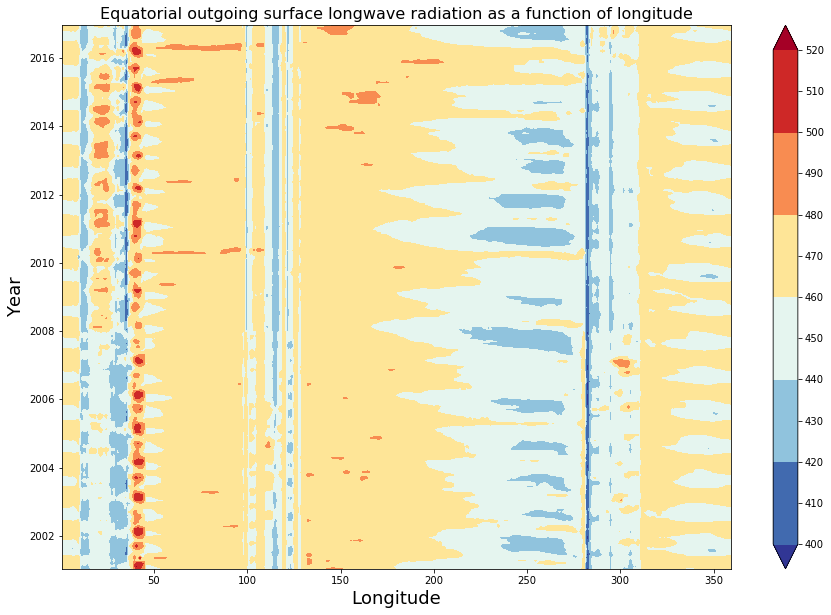

In [7]:
#plot timeseries for outgoing longwave radiation dataset.rlus
#data needs to be sliced just for the equator

datas=dataset.sel(lat=0, method='nearest')
fig = plt.figure(figsize = [15,10])
ax = fig.add_subplot(111)
cs = ax.contourf(datas.lon, datas.time, datas.rlus, cmap='RdYlBu_r', extend='both')
cb = plt.colorbar(cs,ticks=np.arange(380,530+10,10))
ax.set_title('Equatorial outgoing surface longwave radiation as a function of longitude', fontsize=16)
ax.set_xlabel('Longitude', fontsize=18)
ax.set_ylabel('Year', fontsize=18)
plt.show()


## Surface temperature ##

In [8]:
#calculate temperature at SFC

temp = (dataset.rlus/(0.98*5.67e-8))**(1/4)


In [9]:
#calculate SST for equatorial region datas. from the SB law
tempe = (datas.rlus/(0.98*5.67e-8))**(1/4)
#np.amax(tempe)

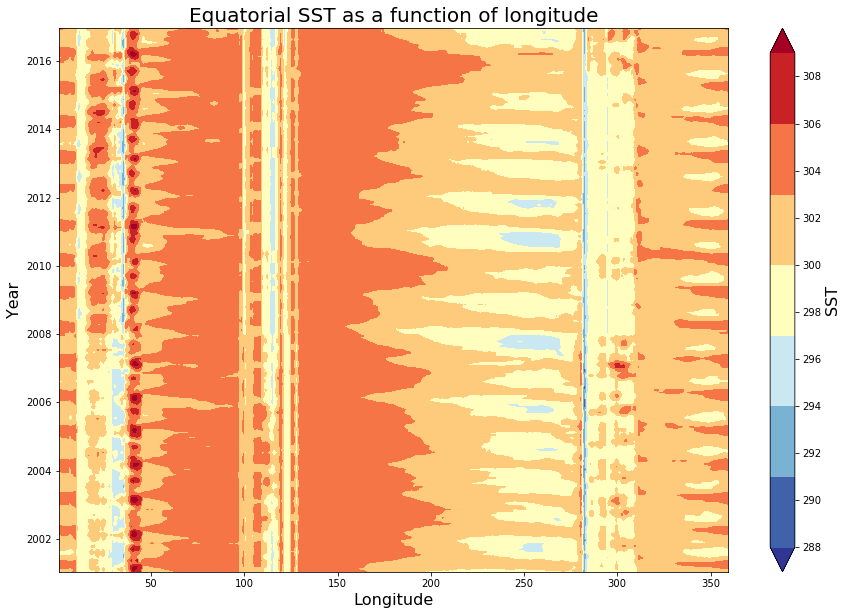

In [10]:
#plot a timeseries of equatorial SST as a function of longitude
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
cs = ax.contourf(datas.lon,datas.time,tempe,cmap='RdYlBu_r',extend='both')
cb = plt.colorbar(cs, ticks=np.arange(280,315+10,2))
cb.set_label('SST',fontsize=16)
ax.set_title('Equatorial SST as a function of longitude',fontsize=20)
ax.set_xlabel('Longitude',fontsize=16)
ax.set_ylabel('Year',fontsize=16)
plt.show()

In [11]:
#calculate zonal mean so that the data only varies temporally and meridionally
tempm = temp.mean(axis=2)
tempm.shape

(192, 180)

<a href="#top">Back to top </a>

<a name="tyler"></a>
# Time series prediction: all do problems, Tyler with data

## Time series prediction: Markov chains and linear inverse modeling

Tyler has climate-pattern index time series by month and day, such as NAO(yyyy,mm) and PDO(yyyy,mm). Let's call a generic one of these V(t) = V(yyyy,mm) for Variable, and assume it is an anomaly (the time mean has been removed). 

We would like to statistically predict these series into the future, by studying how they changed from month in the past. This is like a regression model: 

V(t+1) = c V(t) + residual 

which we could use to estimate c in the normal way. 

A forecast of the predicted signal would simply be an exponential decay of the anomaly at forecast time:

V(leadtime) = V(fcst) exp(-ct)

To make a formula that forecasts a time series similar to the observed, with the predicted signal but a steady variance, we need to add random numbers 

V(t+1) = c V(t) + (1-c) N(0, sd(V))

where the new term is a particular model of the residual as random, uncorrelated noise N with standard deviation equal to that of the total data. 

For 0 < c < 1, this discrete formula is called Markov process (the memory is only one time step; generated value at any time depends only on the value ONE TIME STEP ago). A continuous version is called the AR1 process (autoregressive - one time step), commonly called "red noise" in climate, but Wikipedia redirects that to "brown noise", related to Brownian motion or random walks. 

If **V** is a vector containing 2 or more variables, with two coefficients **c**, 

**V(t+1)** = **V(t)** **c** + residual 

then the *lagged autoregression* **c** is solved for as 

**c** = **V(t)'V(t) \  V(t)'V(t+1)** 

just as in Ivenis' problem above. 

#### Problems for all

1. What does the last formula generate for c=0? For c=1? 

1. Do a univariate red noise (autoregression) computer exercise from one of [these course notebooks](https://github.com/MPOcanes/MPO624-2020/blob/master/Course_Modules_Topics_Notebooks/autoregression_in_time); this is a placeholder, not yet an assignment. 

1. Do a multivariate autoregression computer exercise from one of [these course notebooks](https://github.com/MPOcanes/MPO624-2020/blob/master/Course_Modules_Topics_Notebooks/autoregression_in_time); this is a placeholder, not yet an assignment. 

Tyler, care to try this out with your indices? 

**Link to Tyler's [fork](https://github.com/fensketyler/MPO624-2020). Tyler, feel free to take over & make it make better sense!**

<a href="#top">Back to top </a>

<a name="kelsey"></a>
# Regressions of fields on indices: all do this 

## Global maps associated with time series from certain regions

#### Regress maps to time series with this [web engine](https://www.esrl.noaa.gov/psd/data/correlation/)

#### For everyone
Spend about an hour playing with it. Capture some interesting features and share them with the class. 

Notice the "random" time series. For your favorite signal, compare your result to the identically scaled and colored plot using a random time series. How much of the signal pattern should you trust, based on your record length? 

<a href="#top">Back to top </a>

<a name="haozhe"></a>
# Haozhe, what's your work and project? Got questions?

## Problems we can all appreciate and play with? 

<a href="#top">Back to top </a>